# Imports

In [17]:
# General modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import sep
from tqdm import tqdm
from scipy.stats import binom

# Local modules
import disc_score

# Enable re-load of local modules every time they are called
%load_ext autoreload
%autoreload 2
%aimport numpy 
%aimport pandas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [4]:
cd Documents/CEGIS/DiscSim/

/Users/amrita/Documents/CEGIS/DiscSim


In [5]:
home_folder = 'Documents{0}CEGIS{0}DiscSim'.format(sep)
#filename = '{0}{1}sample ecd child data ADQ.xlsx'.format(home_folder, sep)
filename = 'sample ecd child data ADQ.xlsx'

data = pd.read_excel(filename) # Read data from the excel sheet
variables = data.columns       # Each column is a single variable measured, this gives the names of columns
n_variables = len(variables)

print('The following variables were found in this dataset:')
for v in variables:
    print('    {0}'.format(v))

The following variables were found in this dataset:
    child_id
    stunting_aww
    wasting_aww
    underweight_aww
    gender_cat_ss
    weight_ss
    height_ss
    age_in_months_ss
    haz06_ss
    waz06_ss
    whz06_ss
    bmiz06_ss
    stunting_ss
    wasting_ss
    underweight_ss
    height_aww
    weight_aww
    measurement_date_aww


In [6]:
# To access any of the variables, use data.<variable name> -- for example:
data.child_id

0      2998424
1      3250679
2      3297596
3      3300262
4      3300591
        ...   
480    6469093
481    6469166
482    6470304
483    6472322
484    6474014
Name: child_id, Length: 485, dtype: int64

In [7]:
# To access a particular sample, use data.<variable name>[sample number] -- for example:
data.child_id[53]

4124209

# Identify measured variables

In [8]:
supervisor_variables = []
subordinate_variables = []

for v in variables: # Loop over variables (in each loop iteration, 'v' will take on the value of the next variable)
    
    variable_type = v[v.rindex('_') + 1:] # Returns the characters in v after the last occurence of '_'
    
    if variable_type == 'aww':
        subordinate_variables.append(v)
    else:
        if variable_type == 'ss':
            supervisor_variables.append(v)
            
print('Subordinate variables: {0}'.format(subordinate_variables))
print('Supervisor_variables: {0}'.format(supervisor_variables))

Subordinate variables: ['stunting_aww', 'wasting_aww', 'underweight_aww', 'height_aww', 'weight_aww', 'measurement_date_aww']
Supervisor_variables: ['gender_cat_ss', 'weight_ss', 'height_ss', 'age_in_months_ss', 'haz06_ss', 'waz06_ss', 'whz06_ss', 'bmiz06_ss', 'stunting_ss', 'wasting_ss', 'underweight_ss']


## Find variables measured by both subordinate and supervisor

In [9]:
subordinate_only = []
supervisor_only = []
subordinate_and_supervisor = []

supervisor_variable_names = [v[:v.rindex('_')] for v in supervisor_variables] # Characters in v before the last occurence of '_'

for v in subordinate_variables:
    
    variable_name = v[:v.rindex('_')] # Characters in v before the last occurence of '_'
    
    if variable_name in supervisor_variable_names:
        subordinate_and_supervisor.append(variable_name)
        
    else:
        subordinate_only.append(variable_name)
        
supervisor_only = [v for v in supervisor_variable_names if np.logical_and(np.logical_not(v in subordinate_only),
                                                                         np.logical_not(v in subordinate_and_supervisor))]

print('The following variables are measured by both subordinate and supervisor:')
for v in subordinate_and_supervisor:
    print('    {0}'.format(v))
print('')

print('The following variables are measured only by subordinate:')
for v in subordinate_only:
    print('    {0}'.format(v))
print('')
    
print('The following variables are measured only by supervisor:')
for v in supervisor_only:
    print('    {0}'.format(v))

The following variables are measured by both subordinate and supervisor:
    stunting
    wasting
    underweight
    height
    weight

The following variables are measured only by subordinate:
    measurement_date

The following variables are measured only by supervisor:
    gender_cat
    age_in_months
    haz06
    waz06
    whz06
    bmiz06


# Discrepancy score calculation

## Discrete variables

In [10]:
# Stunting is a ternary variable, with three possible values. 
print('Stunting may be one of the following: {0}'.format(np.unique(data.stunting_aww)))
      
# We want to know how often the subordinate and supervisor reported different stunting values, so a good method for discrepancy score calculation would be percentage of non-matching entries.
score = disc_score.discrepancy_score(data.stunting_aww, data.stunting_ss, "percent_non_match")
print('{0}% of entries are not matching between stunting reported by subordinate and supervisor.'.format(np.round(score, 2)))    
print('')

# Similarly, wasting is a variable, with five possible values:
print('Wasting may be one of the following: {0}'.format(np.unique(data.wasting_aww)))

# Again we want to know how often it was not matching:
score = disc_score.discrepancy_score(data.wasting_aww, data.wasting_ss, "percent_non_match")
print('{0}% of entries are not matching between wasting reported by subordinate and supervisor.'.format(np.round(score, 2)))    
print('')

# Similarly for underweight:
print('Underweight may be one of the following: {0}'.format(np.unique(data.underweight_aww)))

# Again we want to know how often it was not matching:
score = disc_score.discrepancy_score(data.underweight_aww, data.underweight_ss, "percent_non_match")
print('{0}% of entries are not matching between underweight reported by subordinate and supervisor.'.format(np.round(score, 2)))    
print('')


Stunting may be one of the following: ['Normal' 'moderate stunting' 'severe stunting']
27.42% of entries are not matching between stunting reported by subordinate and supervisor.

Wasting may be one of the following: ['Normal' 'Obese' 'Overweight' 'moderate wasting' 'severe wasting']
23.92% of entries are not matching between wasting reported by subordinate and supervisor.

Underweight may be one of the following: ['Normal' 'moderately underweight' 'severely underweight']
21.44% of entries are not matching between underweight reported by subordinate and supervisor.



## Continous variables

In [11]:
# For continuous variables like height and weight, we can use a absolute difference, as we do not expect exact matches. 
print('Absolute difference')
score = disc_score.discrepancy_score(data.height_aww, data.height_ss, "absolute_difference")
print('Height reported by subordinate and supervisor differ by {0} units on average.'.format(np.round(score, 2)))
score = disc_score.discrepancy_score(data.weight_aww, data.weight_ss, "absolute_difference")
print('Weight reported by subordinate and supervisor differ by {0} units on average.'.format(np.round(score, 2)))
print('')

# We can also use a simple difference, in which the sign of the difference matters. These values will be smaller on average, because some of them will be negative and some positive, and they'll cancel each other out.
print('Simple difference')
score = disc_score.discrepancy_score(data.height_aww, data.height_ss, "simple_difference")
print('Height reported by subordinate and supervisor differ by {0} units on average.'.format(np.round(score, 2)))
score = disc_score.discrepancy_score(data.weight_aww, data.weight_ss, "simple_difference")
print('Weight reported by subordinate and supervisor are differ by {0} units on average.'.format(np.round(score, 2)))
print('')

# It may make more sense to calculate difference as a percentage of the supervisor variable:
print('Absolute percent difference')
score = disc_score.discrepancy_score(data.height_aww, data.height_ss, "absolute_percent_difference")
print('Height reported by subordinate and supervisor differ by {0}% of supervisor weight on average.'.format(np.round(score, 2)))
score = disc_score.discrepancy_score(data.weight_aww, data.weight_ss, "absolute_percent_difference")
print('Weight reported by subordinate and supervisor differ by {0}% of supervisor weight on average.'.format(np.round(score, 2)))
print('')

print('Simple percent difference')
score = disc_score.discrepancy_score(data.height_aww, data.height_ss, "percent_difference")
print('Height reported by subordinate and supervisor differ by {0}% of supervisor weight on average.'.format(np.round(score, 2)))
score = disc_score.discrepancy_score(data.weight_aww, data.weight_ss, "percent_difference")
print('Weight reported by subordinate and supervisor are differ by {0}% of supervisor height on average.'.format(np.round(score, 2)))
print('')

Absolute difference
Height reported by subordinate and supervisor differ by 3.84 units on average.
Weight reported by subordinate and supervisor differ by 0.9 units on average.

Simple difference
Height reported by subordinate and supervisor differ by -0.52 units on average.
Weight reported by subordinate and supervisor are differ by 0.06 units on average.

Absolute percent difference
Height reported by subordinate and supervisor differ by 4.66% of supervisor weight on average.
Weight reported by subordinate and supervisor differ by 9.02% of supervisor weight on average.

Simple percent difference
Height reported by subordinate and supervisor differ by -0.35% of supervisor weight on average.
Weight reported by subordinate and supervisor are differ by 1.45% of supervisor height on average.



## Sanity checks

The method discrepancy_score will throw errors if there are issues with the variables entered for comparison. 

### Variable length

In [12]:
# If the two variables have different length:
x = [1, 2, 3, 4, 5]
y = [1, 2, 3, 4, 5, 6]
disc_score.discrepancy_score(x, y, 'simple_difference')

# Data cleaning step: these rows need to be ignored -- or autocalculate stunting, wasting from height weight

ValueError: The two variables must be the same length.

### Data type

In [13]:
# If the two variables are of different types:
disc_score.discrepancy_score(data.stunting_aww, data.height_ss, 'simple_difference')

TypeError: The two variables must be the same type.

# Measure confidence in the discrepancy score

For the rest of this analysis, we'll focus on wasting and use the percentage of non-matching entries as our discrepancy score calculation method.

## Generate a distribution of discrepancy scores using bootstrapping

100%|██████████████████████████████████████| 10000/10000 [00:29<00:00, 339.71it/s]


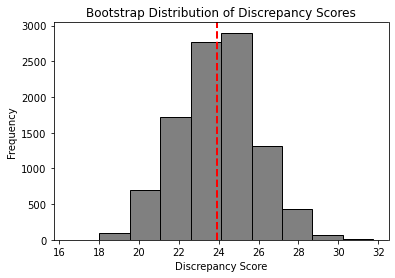

In [14]:
discrepancy_scores = disc_score.bootstrap_distribution(data.wasting_aww, data.wasting_ss, "percent_non_match", n_iterations = 10000)

## Smaller sample size leads to wider bootstrap distribution

This indicates that the wider the bootstrap distribution, the less confident we can be in the discrepancy score measured.

100%|█████████████████████████████████████| 10000/10000 [00:01<00:00, 5872.48it/s]


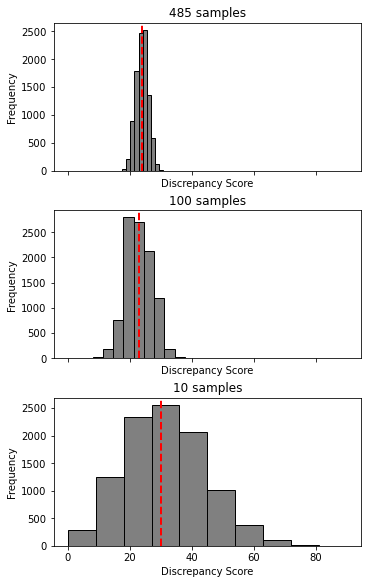

In [134]:
n_samples = [1000, 100, 10]
fig, ax = plt.subplots(nrows = 3, ncols = 1, sharex = True, constrained_layout = True, figsize = [5, 8])

for i in range(3):
    n = n_samples[i]
    if n > len(data.wasting_aww):
        n = len(data.wasting_aww)
    discrepancy_scores = disc_score.bootstrap_distribution(data.wasting_aww[:n], data.wasting_ss[:n], 
                                                           "percent_non_match", n_iterations = 10000,
                                                          ax = ax[i])
    ax[i].set_title('{0} samples'.format(n))

## Generate a null distribution of discrepancy scores by shuffling indices of supervisor variable

100%|██████████████████████████████████████| 10000/10000 [00:14<00:00, 679.26it/s]


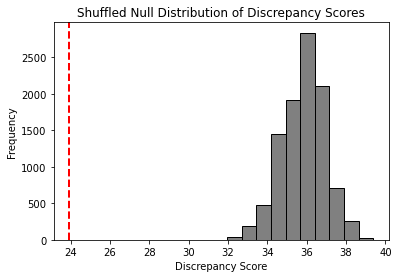

In [138]:
discrepancy_scores = disc_score.shuffle_distribution(data.wasting_aww, data.wasting_ss, "percent_non_match", n_iterations = 10000)

## P-value is the proportion of shuffled samples that have a lower discrepancy score than the real samples.

In [140]:
real_discrepancy_score = disc_score.discrepancy_score(data.wasting_aww, data.wasting_ss, "percent_non_match")

p_val = disc_score.p_value(discrepancy_scores, real_discrepancy_score)
print(p_val)

0.0


## Smaller sample size leads to larger p-value

100%|███████████████████████████| 10000000/10000000 [17:44<00:00, 9395.77it/s]


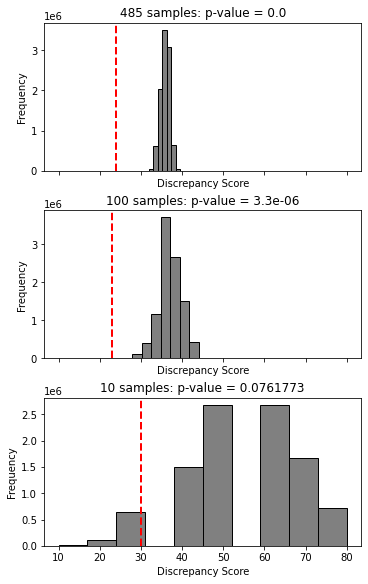

In [143]:
n_samples = [1000, 100, 10]
fig, ax = plt.subplots(nrows = 3, ncols = 1, sharex = True, constrained_layout = True, figsize = [5, 8])

for i in range(3):
    n = n_samples[i]
    if n > len(data.wasting_aww):
        n = len(data.wasting_aww)
    discrepancy_scores = disc_score.shuffle_distribution(data.wasting_aww[:n], data.wasting_ss[:n], 
                                                           "percent_non_match", n_iterations = 1000,
                                                          ax = ax[i])
    real_discrepancy_score = disc_score.discrepancy_score(data.wasting_aww[:n], data.wasting_ss[:n], "percent_non_match")
    
    p_value = disc_score.p_value(discrepancy_scores, real_discrepancy_score)
    
    ax[i].set_title('{0} samples: p-value = {1}'.format(n, p_value))

# Find number of samples required to detect certain discrepancy

Note: this only applies to discrete variables where there are two possible outcomes for each entry: matching or not matching, between subordinate and supervisor. 

We will model discrepancy of a discrete variable as a binomial random variable with n samples and probability of success = d (here, success means non-matching values between subordinate and supervisor). That is, the "true discrepancy score" is d. 

Then the observed discrepancy score is a random variable drawn from the distribution binomial(n, d). Let us see what this distribution looks like:

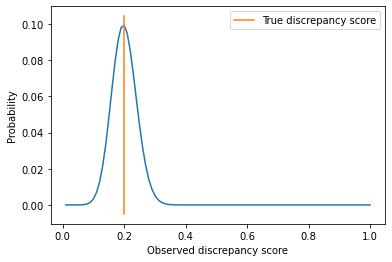

In [28]:
n = 100 # Number of samples
d = 0.2 # 'True' discrepancy score of this worker: 20% of samples are mismatching with supervisor.
x = np.linspace(1, n, 100) 

plt.figure()
plt.plot(x/n, binom.pmf(x, n, d))
plt.xlabel('Observed discrepancy score')
plt.ylabel('Probability')
plt.plot([d, d], plt.ylim(), label = 'True discrepancy score')
plt.legend()

If we increase the number of samples, the distribution of observed discrepancy scores will be 'tighter' around the true discrepancy score. 

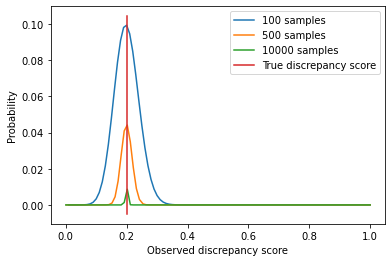

In [34]:
d = 0.2 # 'True' discrepancy score of this worker: 20% of samples are mismatching with supervisor.

plt.figure()

for n in (100, 500, 10000):
    
    x = np.linspace(1, n, 100).astype(int)
    prob = binom.pmf(x, n, d)
    plt.plot(x/n, prob, label = '{0} samples'.format(n))
    
plt.xlabel('Observed discrepancy score')
plt.ylabel('Probability')
plt.plot([d, d], plt.ylim(), label = 'True discrepancy score')
plt.legend()

We will now define a threshold of discrepancy score, below which workers will be classified as 'green band'. 

In [35]:
t1 = 0.3 # Threshold for green band (workers with discrepancy score < 0.3 are in green band)

The cdf of the binomial distribution gives the probability of classifying our worker above, with true discrepancy d = 0.2, as a green band worker. 

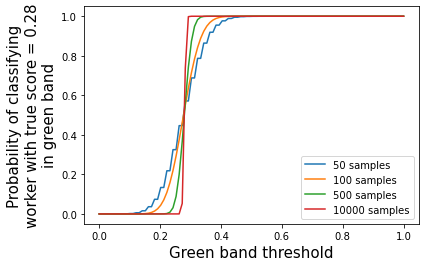

In [59]:
d = 0.28
t = np.linspace(0, 1, 100)
plt.figure()

for n in (50, 100, 500, 10000):

    prob = binom.cdf(t*n, n, d)
    plt.plot(t, prob, label = '{0} samples'.format(n))
    
plt.xlabel('Green band threshold', fontsize = 15)
plt.ylabel('Probability of classifying\nworker with true score = {0}\nin green band'.format(d), fontsize = 15)
plt.legend()


Let us zoom in around the threshold t1 = 0.3

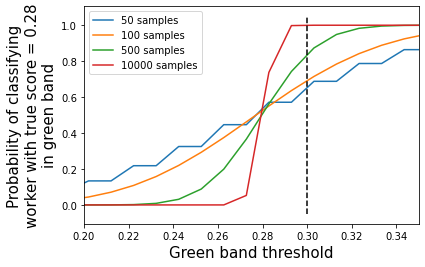

In [62]:
t = np.linspace(0, 1, 100)
plt.figure()

for n in (50, 100, 500, 10000):

    prob = binom.cdf(t*n, n, d)
    plt.plot(t, prob, label = '{0} samples'.format(n))
    
plt.xlim((0.2, 0.35))
plt.plot((t1, t1), plt.ylim(), color = 'k', linestyle = '--')
plt.xlabel('Green band threshold', fontsize = 15)
plt.ylabel('Probability of classifying\nworker with true score = {0}\nin green band'.format(d), fontsize = 15)
plt.legend()


We can see that the probability of classifying this worker as green increases with the sample size, which makes sense, because more samples means our estimate of the discrepancy score will be closer to the true discrepancy score. In particular, the probabilities are:

In [63]:
for n in (50, 100, 500, 10000):

    print('{0} samples: probability = {1}'.format(n, binom.cdf(int(t1*n), n, d)))

50 samples: probability = 0.6878985972817714
100 samples: probability = 0.7149122007480799
500 samples: probability = 0.8520470694882497
10000 samples: probability = 0.9999954133880968


Let's say we want to figure out the appropriate number of samples to get good classification. Let us define an 'accuracy' a = 0.02, and say that if the true discrepancy score is less than t1 - a, we would like to classify this worker as green band with high probability. Let that probability be 90%, or 0.9. 

Then, we can find the minimum number of samples for which true discrepancy score of 0.28 (or lower) will be classified as green band with probability 0.9.

To do this, we will set some initial values of n (two guesses) and calculate the probability. Then we will do a binary search: if the probability is < 0.9, we will double n and if the probability is > 0.9, we will make n half until we get close enough to the desired probability 0.9.

In [81]:
a = 0.02 # Desired accuracy
tolerance = 0.001 # Looking for probability between 0.899 and 0.901 
n_high = 5000 # Initial high guess for n
n_low = 50 # Initial low guess for n 
p_high = binom.cdf(int(t1*n_high), n_high, t1 - a)
p_low = binom.cdf(int(t1*n_low), n_low, t1 - a)
p = 0.9 # Desired probability of correct classification

# assert(p_low < p < p_high)

while np.abs(p_high - p) > tolerance and n_low < n_high + 1:

    if p_high > p:
        if p_low > p:
            n_high = n_low
            n_low = n_low/2
        else:
            # n_high = int((n_high + n_low)/2)
            n_mid = int((n_high + n_low)/2)
            p_mid = binom.cdf(int(t1*n_mid), n_mid, t1 - a)
            if(p_mid > p):
                n_high = n_mid
            else:
                n_low = n_mid

    else:
        n_low = n_high
        n_high = int(n_high*2)
        
    p_high = binom.cdf(int(t1*n_high), n_high, t1 - a)
    p_low = binom.cdf(int(t1*n_low), n_low, t1 - a)
    
    
print('To correctly classify workers with discrepancy score < {0} {1}% of the time, {2} samples are required.'.format(t1 - a, int(p*100), n_high))


To correctly classify workers with discrepancy score < 0.27999999999999997 90% of the time, 856 samples are required.


Separately, we will have a threshold above which workers will be classified as 'red band'.

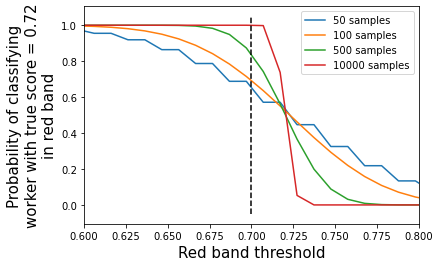

In [75]:
t2 = 0.7 # Threshold for red band (workers with discrepancy score > 0.7 are in red band)
d = 0.72
t = np.linspace(0, 1, 100)
plt.figure()

for n in (50, 100, 500, 10000):

    prob = 1 - binom.cdf(t*n, n, d)
    plt.plot(t, prob, label = '{0} samples'.format(n))
    
plt.xlim((0.6, 0.8))
plt.plot((t2, t2), plt.ylim(), color = 'k', linestyle = '--')
plt.xlabel('Red band threshold', fontsize = 15)
plt.ylabel('Probability of classifying\nworker with true score = {0}\nin red band'.format(d), fontsize = 15)
plt.legend()

In [76]:
for n in (50, 100, 500, 10000):

    print('{0} samples: probability = {1}'.format(n, 1 - binom.cdf(int(t2*n), n, d)))

50 samples: probability = 0.571392016126593
100 samples: probability = 0.6362159151362563
500 samples: probability = 0.8281898755916329
10000 samples: probability = 0.9999949221278859


In [82]:
a = 0.02 # Desired accuracy
tolerance = 0.001 # Looking for probability between 0.899 and 0.901 
n_high = 100 # Initial high guess for n
n_low = 50 # Initial low guess for n 
p_high = 1 - binom.cdf(int(t2*n_high), n_high, t2 + a)
p_low = 1 - binom.cdf(int(t2*n_low), n_low, t2 + a)
p = 0.9 # Desired probability of correct classification

while np.abs(p_high - p) > tolerance:

    if p_high > p:
        if p_low > p:
            n_high = n_low
            n_low = n_low/2
        else:
            n_high = int((n_high + n_low)/2)
    else:
        n_low = n_high
        n_high = int(n_high*2)
        
    p_high = 1 - binom.cdf(int(t2*n_high), n_high, t2 + a)
    p_low = 1 - binom.cdf(int(t2*n_low), n_low, t2 + a)
    
    
print('To correctly classify workers with discrepancy score > {0} {1}% of the time, {2} samples are required.'.format(t2 + a, int(p*100), n_high))


To correctly classify workers with discrepancy score > 0.72 90% of the time, 866 samples are required.


Now if we want both these conditions to be satisfied simultaneously, we cannot enforce the tolerance on the upper side (i.e. we cannot get minimum number of samples for both conditions). 

In [104]:
a = 0.02 # Desired accuracy
tolerance = 0.001 # Looking for probability greater than 0.899 for both conditions 

n_high = 100000 # Initial high guess for n
n_low = 1 # Initial low guess for n 

t1 = 0.3 # Green band threshold
t2 = 0.7 # Red band threshold

p_high1 = binom.cdf(int(t1*n_high), n_high, t1 - a)
p_low1 = binom.cdf(int(t1*n_low), n_low, t1 - a)

p_high2 = 1 - binom.cdf(int(t2*n_high), n_high, t2 + a)
p_low2 = 1 - binom.cdf(int(t2*n_low), n_low, t2 + a)

p = 0.9 # Desired probability of correct classification

while np.logical_or(p_high1 > p, p_high2 > p):
    
    if p_low1 > p:
        if p_low2 > p:
            n_high = n_low
            n_low = int(n_low/2)
        else:
            n_high = int((n_high + n_low)/2)
    else:
        n_high = int((n_high + n_low)/2)
        
    p_high1 = binom.cdf(int(t1*n_high), n_high, t1 - a)
    p_low1 = binom.cdf(int(t1*n_low), n_low, t1 - a)

    p_high2 = 1 - binom.cdf(int(t2*n_high), n_high, t2 + a)
    p_low2 = 1 - binom.cdf(int(t2*n_low), n_low, t2 + a)
    
    if np.logical_and(p_high1 < p, p_high2 < p):
        n_low = n_high
        n_high = int(2*n_high)
    
        p_high1 = binom.cdf(int(t1*n_high), n_high, t1 - a)
        p_low1 = binom.cdf(int(t1*n_low), n_low, t1 - a)

        p_high2 = 1 - binom.cdf(int(t2*n_high), n_high, t2 + a)
        p_low2 = 1 - binom.cdf(int(t2*n_low), n_low, t2 + a)
    
    if np.logical_or(p_high1 <= p - tolerance, p_high2 <= p - tolerance):
        break
        
print('To correctly classify workers with discrepancy score < {0} and workers with discrepancy score > {1} {2}% of the time, {3} samples are required.'.format(t1 - a, t2 + a, int(p*100), n_high))


To correctly classify workers with discrepancy score < 0.27999999999999997 and workers with discrepancy score > 0.72 90% of the time, 830 samples are required.
